# Classifier comparison on EFRI movement decoding task
We compare the performance of MORF against several other classifiers on raw stereo-EEG (sEEG) data. Patients in the EFRI cohort were tasked with using a manipulandum to maneuver a cursor from a central starting point to a target zone located either up, down, left, or right of center.

## Experimental Setup
The raw sEEG data is a multivariate time series of dimension $N \times C \times T$, where $N$ is the number of trials the task was performed, $C$ is the number of sEEG implantations, and $T$ is the number of time steps. Each patient typically performed around $N=75$ to $N=100$ trials of the experiment successfully and had $C=70$ to $C=100$ channel recordings. The time window in consideration begins -0.2 s before the recorded instance the patient leaves the central starting point until 0.5 s after they have left the central starting point. The sampling frequency was downsampled to 500 Hz, yielding $T = 350$. The labels are integer-encoded directions $\{0,1,2,3\}$ corresponding to down, right, up, and left, respectively.

We analyze the performance of several classifiers against MORF in this multi-class classification problem, primarily evaluating based on the macro-averaged one vs. rest area under the receiver operating curve (OvR AUROC). We show the results over 5-fold stratified cross validation.

by Chester Huynh and Adam Li, *March 2021*

In [32]:
import json
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# from mne_bids import BIDSPath
# from ptitprince import RainCloud
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

plt.rcParams.update({
    "font.family": "sans-serif", 
    "font.size": 22,
    "figure.titlesize": "xx-large",
    "axes.titlesize": "xx-large",
    "axes.labelsize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large"
})
# sns.set_theme()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Large time window with shuffled channels

In [33]:
import json
cohort = [
    "efri07",
    "efri13",
    "efri14",
    "efri18",
    "efri20",
]
bids_root = Path("/Users/rflperry/Documents/jovo_lab/morf/morf-study")
# bids_root = Path('/Users/adam2392/OneDrive - Johns Hopkins/efri/')
derivatives_path = bids_root / "derivatives" / "decode_directionality"

figures_path = Path(os.path.abspath(" ")).parents[1] / "figures/"
# figures_path = Path('/Users/adam2392/Dropbox/morf-study/derivatives/figures/')


cohort_clf_scores = defaultdict(dict)

# Create mapping from saved filename and figure name
clf_names_for_figure = {
    "MT-MORF": "MORF", 
    "SPORF": "SPORF",
    "RF": "RF", 
    "kNN": "kNN",
    "XGB": "XGB", 
    "MLP": "MLP", 
    "ConvNet": "ConvNet"
}
for subject in cohort:
    for clf_fname, clf_figure_name in clf_names_for_figure.items():
        with open(
            derivatives_path / f"{subject}/trial_specific_window_shuffle=True/time_domain/{subject}_{clf_fname}_results.json", "r"
        ) as f:
            cohort_clf_scores[subject][clf_figure_name] = json.load(f)

In [34]:
# df.loc[df.groupby("Subject")[""].idxmin()]
metric = 'roc_auc_ovr'
df = []
for subject, clf_scores in cohort_clf_scores.items():
    for clf_name, scores in clf_scores.items():
        df.append([subject, clf_name, scores[f"test_{metric}"]])
df = pd.DataFrame(df, columns=["Subject", "Classifier", metric])
df = pd.DataFrame({"Subject": np.repeat(df["Subject"].values, df[metric].str.len()),
                        "Classifier": np.repeat(df["Classifier"].values, df[metric].str.len()),
                        metric: np.concatenate(df[metric].values)})
print(df.shape)
display(df.head())

(175, 3)


Subject Classifier  roc_auc_ovr
0  efri07       MORF     0.855492
1  efri07       MORF     0.808081
2  efri07       MORF     0.840909
3  efri07       MORF     0.744003
4  efri07       MORF     0.801452

In [35]:
group_cols = ["Classifier", 'Subject']

# create a new DataFrame with a MultiIndex consisting of the group_cols
# and a column for the mean of each column in metric_cols
aggs = df.groupby(group_cols)[metric].median()
# remove the metric_cols from df because we are going to replace them
# with the means in aggs
df.drop(metric, axis=1, inplace=True)
# dedupe to leave only one row with each combination of group_cols
# in df
df.drop_duplicates(subset=group_cols, keep='last', inplace=True)
# add the mean columns from aggs into df
df = df.merge(right=aggs, right_index=True, left_on=group_cols, how='right')

print(df.shape)
display(df.head())

(35, 3)


Subject Classifier  roc_auc_ovr
4   efri07       MORF     0.808081
9   efri07      SPORF     0.858752
14  efri07         RF     0.863005
19  efri07        kNN     0.691288
24  efri07        XGB     0.727972

In [36]:
# Constants for plotting
palette = {
    "MORF":"#e41a1c",
    "SPORF":"#4daf4a",
    "MLP":"#984ea3",
    "SVM":"#a65628", 
    "Log. Reg": "#999999", 
    "XGB":"#cc99ff",
    "ConvNet":"#377eb8",
    "RF":"#ff7f00", 
    "kNN": "#ffff33", 
    "Lin. SVM":"#f781bf"
}
label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

In [37]:
def plot_directionality_comparison(cohort_clf_scores, metric="roc_auc_ovr", ax=None):
    sns.set_style('darkgrid')
    sns.set_context('paper')
    if ax is None:    
        width = 8
        aspect_ratio = 3/4  # 4:3 aspect ratio
        fig, ax = plt.subplots(figsize=(width, width*aspect_ratio), dpi=300, facecolor='w')

    if metric not in ["roc_auc_ovr", "accuracy", "cohen_kappa_score"]:
        raise ValueError("metric must be one of roc_auc_ovr, accuracy or cohen_kappa_score")

    df = []
    for subject, clf_scores in cohort_clf_scores.items():
        for clf_name, scores in clf_scores.items():
            df.append([subject, clf_name, scores[f"test_{metric}"]])
    df = pd.DataFrame(df, columns=["Subject", "Classifier", metric])
    df = pd.DataFrame({"Subject": np.repeat(df["Subject"].values, df[metric].str.len()),
                            "Classifier": np.repeat(df["Classifier"].values, df[metric].str.len()),
                            metric: np.concatenate(df[metric].values)})
    order = df['Classifier'].unique()
    
    # group by subject statistics
    group_cols = ["Classifier", 'Subject']

    # create a new DataFrame with a MultiIndex consisting of the group_cols
    # and a column for the mean of each column in metric_cols
    aggs = df.groupby(group_cols)[metric].median()
    # remove the metric_cols from df because we are going to replace them
    # with the means in aggs
    df.drop(metric, axis=1, inplace=True)
    # dedupe to leave only one row with each combination of group_cols
    # in df
    df.drop_duplicates(subset=group_cols, keep='last', inplace=True)
    # add the mean columns from aggs into df
    df = df.merge(right=aggs, right_index=True, left_on=group_cols, how='right')

    sns.stripplot(x="Classifier", y=metric, data=df, 
                  order=order, hue='Subject',
                  ax=ax)
    
    # Set labels and titles
    ylabel = {
        "roc_auc_ovr": "ROC AUC One vs. Rest",
        "accuracy": "Accuracy",
        "cohen_kappa_score": "Cohen Kappa Score"
    }
    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=45, ha="right")
    ax.set_xlabel("Classifier")
    ax.set_ylabel(f"Cross-Validated {ylabel[metric]}")
    ax.set_title(f"Directionality Decoding Performance on Raw sEEG Recordings")
    legendlabel = {
        "roc_auc_ovr": "ROC AUC One vs. Rest (MORF)",
        "accuracy": "Accuracy (MORF)",
        "cohen_kappa_score": "Cohen Kappa Score (MORF)",
    }

    median_width = 0.4
    for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
        sample_name = text.get_text()  # "X" or "Y"

        # calculate the median value for all replicates of either X or Y
        median_val = df[df["Classifier"] == sample_name][metric].median()

        # plot horizontal lines across the column, centered on the tick
        ax.plot(
            [tick - median_width / 2, tick + median_width / 2],
            [median_val, median_val],
            lw=4,
            color="k",
        )

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

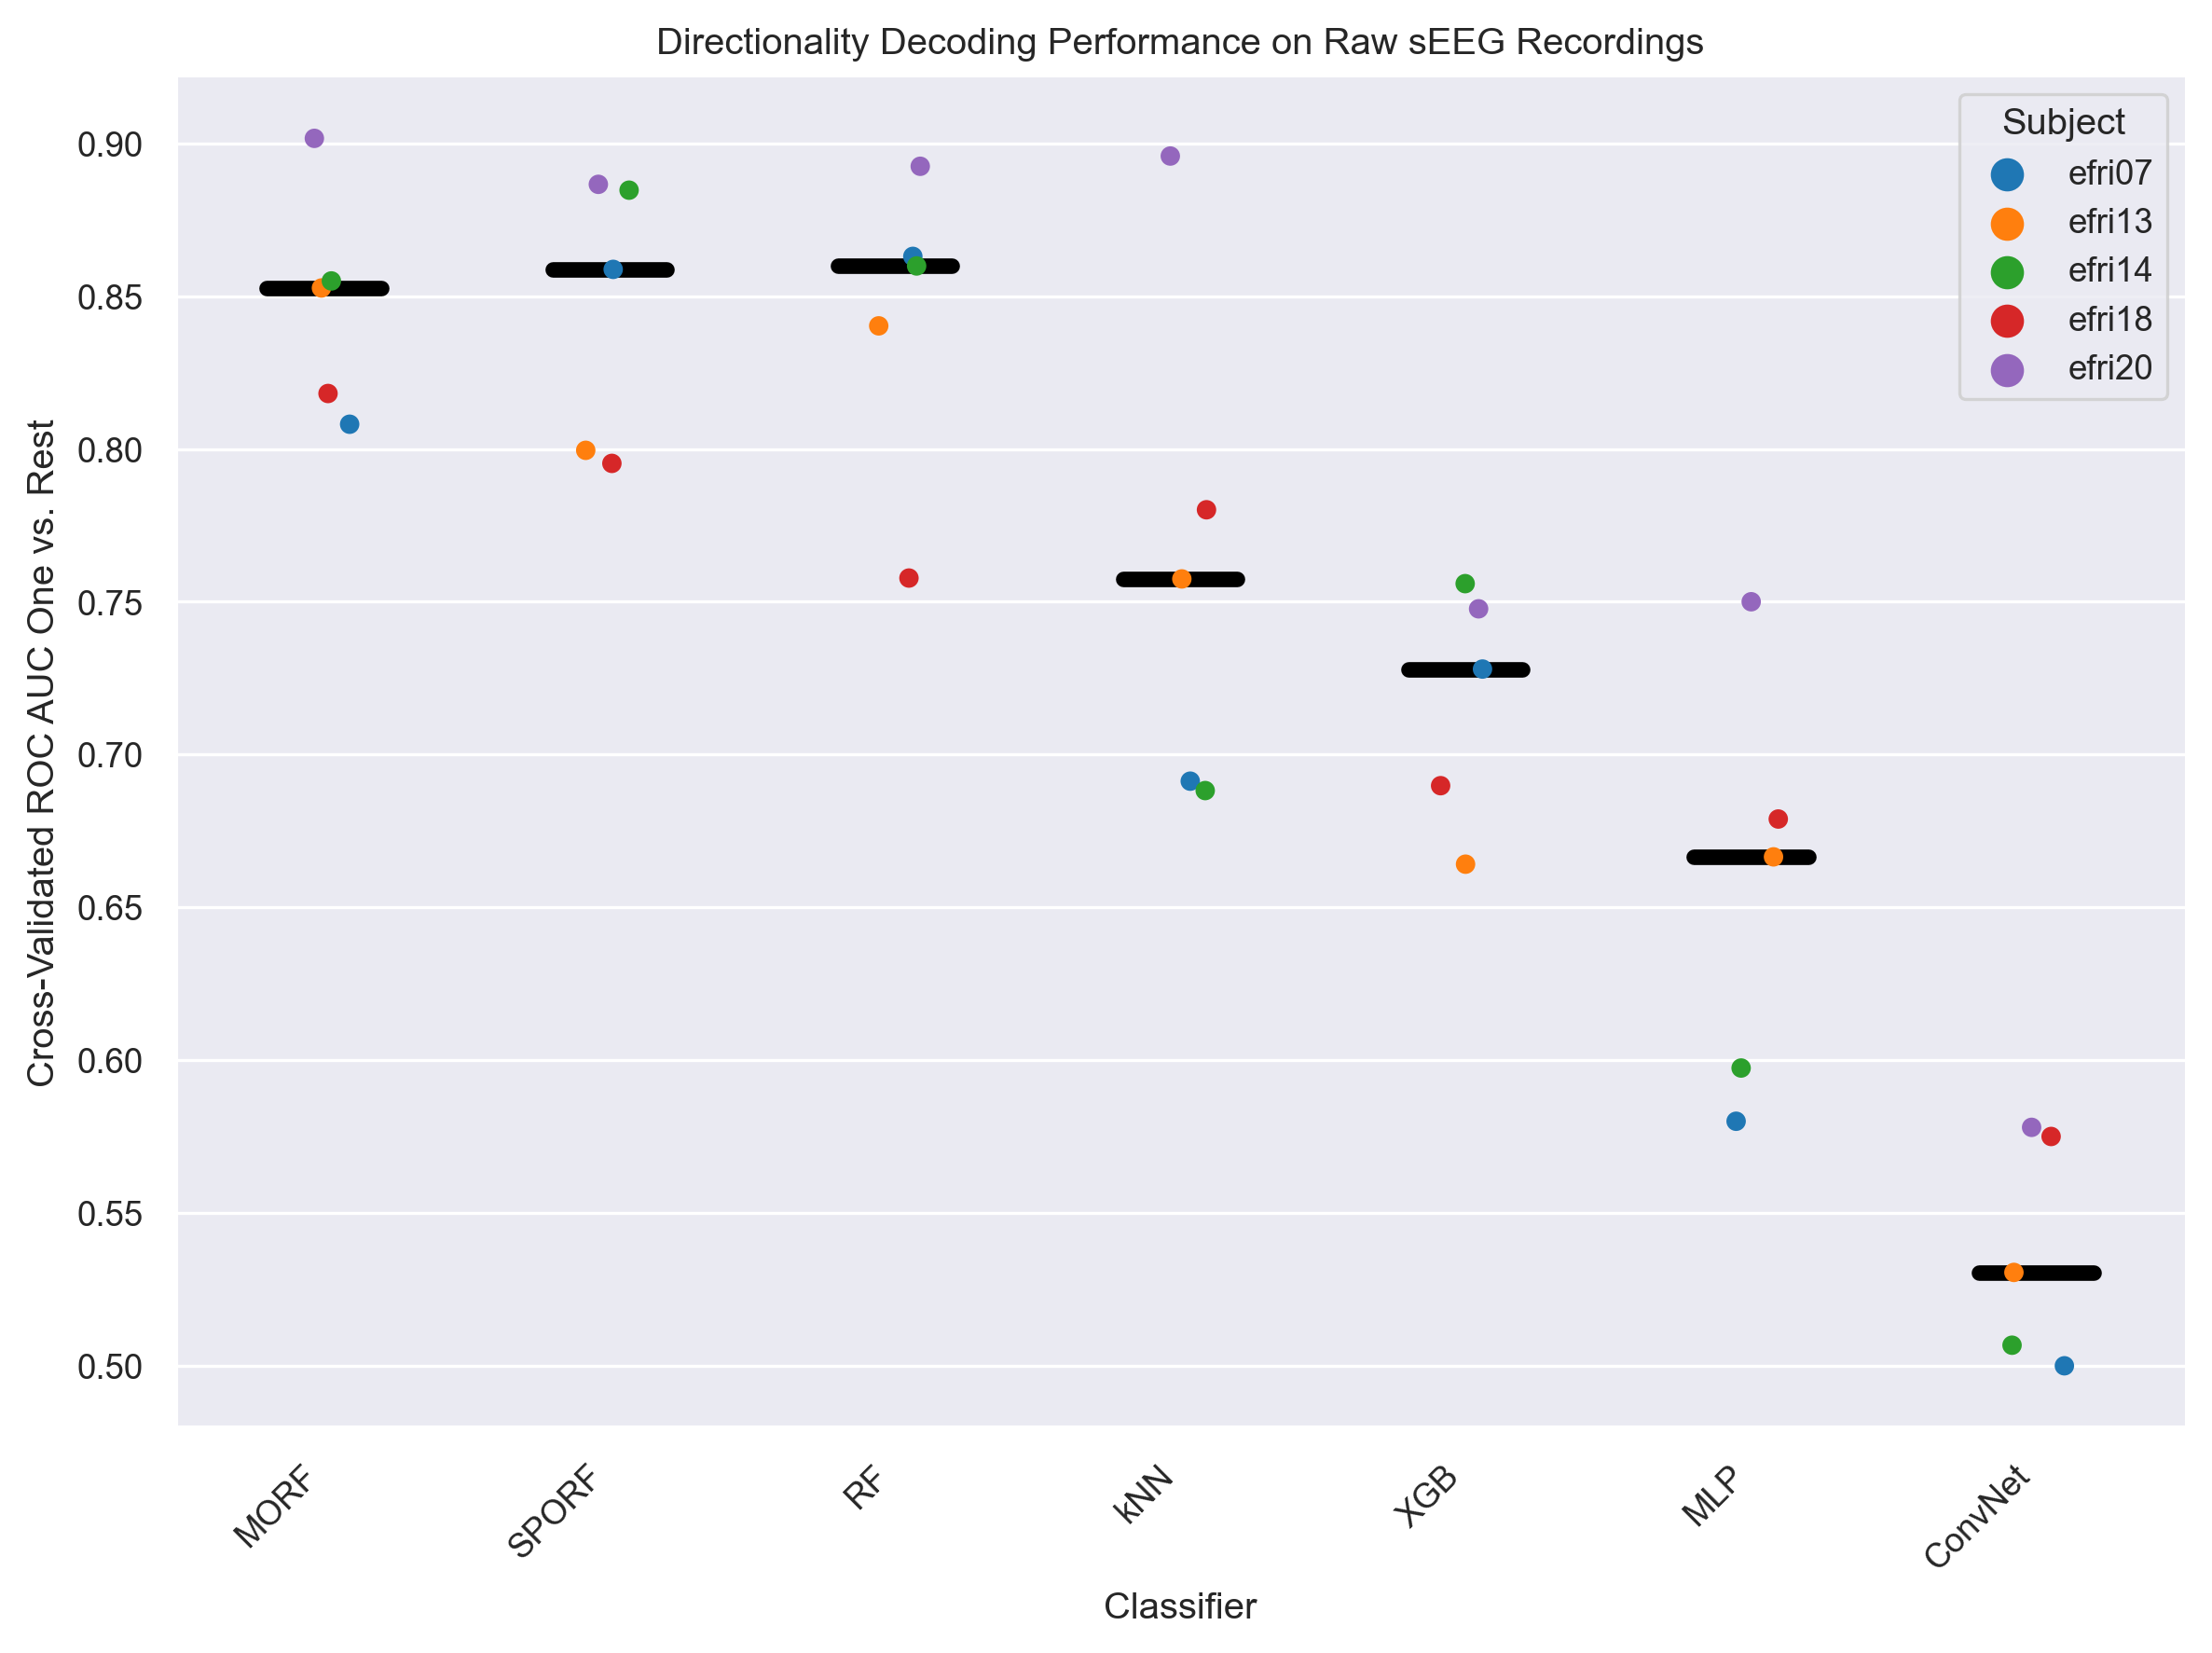

In [39]:
width = 8
aspect_ratio = 3/4  # 4:3 aspect ratio
fig, ax = plt.subplots(figsize=(width, width*aspect_ratio), dpi=300, facecolor='w')
plot_directionality_comparison(cohort_clf_scores, "roc_auc_ovr", ax=ax)
fig.tight_layout()
# plt.savefig(figures_path / "pdf/efri_directionality_decoding_auroc.pdf", bbox_inches='tight');
plt.show()

## Fixed time window without shuffling channels

In [40]:
import json
cohort = [
    "efri07",
    "efri13",
    "efri14",
    "efri18",
    "efri20",
]
bids_root = Path("/Users/rflperry/Documents/jovo_lab/morf/morf-study")
# bids_root = Path('/Users/adam2392/OneDrive - Johns Hopkins/efri/')
derivatives_path = bids_root / "derivatives" / "decode_directionality"

figures_path = Path(os.path.abspath(" ")).parents[1] / "figures/"
# figures_path = Path('/Users/adam2392/Dropbox/morf-study/derivatives/figures/')


cohort_clf_scores = defaultdict(dict)

# Create mapping from saved filename and figure name
clf_names_for_figure = {
    "MT-MORF": "MORF", 
    "SPORF": "SPORF",
    "RF": "RF", 
    "kNN": "kNN",
    "XGB": "XGB", 
    "MLP": "MLP", 
    "ConvNet": "ConvNet"
}
for subject in cohort:
    for clf_fname, clf_figure_name in clf_names_for_figure.items():
        with open(
            derivatives_path / f"{subject}/tmin=-0.2_tmax=0.5/time_domain/{subject}_{clf_fname}_results.json", "r"
        ) as f:
            cohort_clf_scores[subject][clf_figure_name] = json.load(f)

In [192]:
cohort_clf_scores

defaultdict(dict,
            {'efri07': {'MORF': {'fit_time': [0.4655942916870117,
                0.504164457321167,
                0.5206952095031738,
                0.495023250579834,
                0.5029428005218506],
               'score_time': [0.058496713638305664,
                0.04922819137573242,
                0.051175832748413086,
                0.056597232818603516,
                0.05556917190551758],
               'test_accuracy': [0.3125,
                0.6,
                0.5333333333333333,
                0.5333333333333333,
                0.4666666666666667],
               'train_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0],
               'test_cohen_kappa_score': [0.048648648648648596,
                0.4545454545454546,
                0.37869822485207094,
                0.35185185185185186,
                0.281437125748503],
               'train_cohen_kappa_score': [1.0, 1.0, 1.0, 1.0, 1.0],
               'test_roc_auc_ovr': [0.7455965909090909,
    

In [197]:
metric = 'cohen_kappa_score'
df = []
for subject, clf_scores in cohort_clf_scores.items():
    for clf_name, scores in clf_scores.items():
        for fold, score in enumerate(scores[f"test_{metric}"]):
            df.append([subject, clf_name, fold, score])
df = pd.DataFrame(df, columns=["Subject", "Classifier", "Fold", "Cohen\'s Kappa"])

In [206]:
from scipy.stats import wilcoxon

morf_scores = df[df['Classifier'] == 'MORF']['Cohen\'s Kappa'].to_numpy()
for clf in df['Classifier'].unique()[1:]: # exclude MORF
    print(clf)
    alt_scores = df[df['Classifier'] == clf]['Cohen\'s Kappa'].to_numpy()
    median_diff = np.median(morf_scores - alt_scores)
    print(f'Median diff: {median_diff:.3f}')
    stat, pval = wilcoxon(morf_scores, alt_scores, alternative='greater')
    print(f'Wilcoxon stat, pvalue: {stat:.3f}, {pval:.3f}')

SPORF
Median diff: 0.002
Wilcoxon stat, pvalue: 163.000, 0.495
RF
Median diff: -0.000
Wilcoxon stat, pvalue: 146.000, 0.545
kNN
Median diff: 0.050
Wilcoxon stat, pvalue: 170.000, 0.284
XGB
Median diff: 0.060
Wilcoxon stat, pvalue: 218.000, 0.026
MLP
Median diff: 0.040
Wilcoxon stat, pvalue: 175.000, 0.130
ConvNet
Median diff: 0.281
Wilcoxon stat, pvalue: 325.000, 0.000


In [204]:
df[df['Classifier'] == 'MORF']['Cohen\'s Kappa'].to_numpy() - df[df['Classifier'] == 'SPORF']['Cohen\'s Kappa'].to_numpy() 

array([-8.17861340e-02,  9.09090909e-02,  8.87573964e-02,  1.01851852e-01,
       -2.66755645e-01,  6.56529444e-02,  6.01580966e-02, -1.21668299e-01,
        2.02731004e-03,  5.40404040e-02, -5.64080312e-02,  4.82097514e-02,
        1.55574688e-01,  1.61521067e-03, -2.06800101e-01,  2.22044605e-16,
        5.78444544e-02, -1.11627907e-01, -6.33315008e-03,  5.55555556e-02,
        1.11111111e-01, -1.11368910e-01, -1.16161616e-01,  1.74087134e-01,
       -5.98452883e-02])

In [41]:
# df.loc[df.groupby("Subject")[""].idxmin()]
metric = 'roc_auc_ovr'
df = []
for subject, clf_scores in cohort_clf_scores.items():
    for clf_name, scores in clf_scores.items():
        df.append([subject, clf_name, scores[f"test_{metric}"]])
df = pd.DataFrame(df, columns=["Subject", "Classifier", metric])
df = pd.DataFrame({"Subject": np.repeat(df["Subject"].values, df[metric].str.len()),
                        "Classifier": np.repeat(df["Classifier"].values, df[metric].str.len()),
                        metric: np.concatenate(df[metric].values)})
print(df.shape)
display(df.head())

(175, 3)


Subject Classifier  roc_auc_ovr
0  efri07       MORF     0.745597
1  efri07       MORF     0.897727
2  efri07       MORF     0.758005
3  efri07       MORF     0.692866
4  efri07       MORF     0.774621

In [42]:
group_cols = ["Classifier", 'Subject']

# create a new DataFrame with a MultiIndex consisting of the group_cols
# and a column for the mean of each column in metric_cols
aggs = df.groupby(group_cols)[metric].median()
# remove the metric_cols from df because we are going to replace them
# with the means in aggs
df.drop(metric, axis=1, inplace=True)
# dedupe to leave only one row with each combination of group_cols
# in df
df.drop_duplicates(subset=group_cols, keep='last', inplace=True)
# add the mean columns from aggs into df
df = df.merge(right=aggs, right_index=True, left_on=group_cols, how='right')

print(df.shape)
display(df.head())

(35, 3)


Subject Classifier  roc_auc_ovr
4   efri07       MORF     0.758005
9   efri07      SPORF     0.745303
14  efri07         RF     0.813876
19  efri07        kNN     0.689710
24  efri07        XGB     0.609848

In [43]:
# Constants for plotting
palette = {
    "MORF":"#e41a1c",
    "SPORF":"#4daf4a",
    "MLP":"#984ea3",
    "SVM":"#a65628", 
    "Log. Reg": "#999999", 
    "XGB":"#cc99ff",
    "ConvNet":"#377eb8",
    "RF":"#ff7f00", 
    "kNN": "#ffff33", 
    "Lin. SVM":"#f781bf"
}
label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

In [189]:
def plot_directionality_comparison(cohort_clf_scores, metric="roc_auc_ovr", ax=None):
    if ax is None:    
        width = 8
        aspect_ratio = 3/4  # 4:3 aspect ratio
        fig, ax = plt.subplots(figsize=(width, width*aspect_ratio), dpi=300, facecolor='w')

    if metric not in ["roc_auc_ovr", "accuracy", "cohen_kappa_score"]:
        raise ValueError("metric must be one of roc_auc_ovr, accuracy or cohen_kappa_score")

    df = []
    for subject, clf_scores in cohort_clf_scores.items():
        for clf_name, scores in clf_scores.items():
            df.append([subject, clf_name, scores[f"test_{metric}"]])
    df = pd.DataFrame(df, columns=["Subject", "Classifier", metric])
    df = pd.DataFrame({"Subject": np.repeat(df["Subject"].values, df[metric].str.len()),
                       "Classifier": np.repeat(df["Classifier"].values, df[metric].str.len()),
                        metric: np.concatenate(df[metric].values)})
    order = df['Classifier'].unique()
    
    # group by subject statistics
    group_cols = ["Classifier", 'Subject']

    # create a new DataFrame with a MultiIndex consisting of the group_cols
    # and a column for the mean of each column in metric_cols
    aggs = df.groupby(group_cols)[metric].median()
    # remove the metric_cols from df because we are going to replace them
    # with the means in aggs
    df.drop(metric, axis=1, inplace=True)
    # dedupe to leave only one row with each combination of group_cols
    # in df
    df.drop_duplicates(subset=group_cols, keep='last', inplace=True)
    # add the mean columns from aggs into df
    df = df.merge(right=aggs, right_index=True, left_on=group_cols, how='right')

    sns.stripplot(x="Classifier", y=metric, data=df, 
                  order=order, hue='Subject',
                  ax=ax)
    
    # Set labels and titles
    ylabel = {
        "roc_auc_ovr": "ROC AUC (One vs. Rest)",
        "accuracy": "Accuracy",
        "cohen_kappa_score": "Cohen Kappa Score"
    }
    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=45, ha="right")
    ax.set_xlabel("Classifier")
    ax.set_ylabel(f"{ylabel[metric]}")
    # ax.set_title(f"Directionality Decoding Performance\non Raw sEEG Recordings")
    legendlabel = {
        "roc_auc_ovr": "ROC AUC One vs. Rest (MORF)",
        "accuracy": "Accuracy (MORF)",
        "cohen_kappa_score": "Cohen Kappa Score (MORF)",
    }

    median_width = 0.4
    for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
        sample_name = text.get_text()  # "X" or "Y"

        # calculate the median value for all replicates of either X or Y
        median_val = df[df["Classifier"] == sample_name][metric].median()

        # plot horizontal lines across the column, centered on the tick
        ax.plot(
            [tick - median_width / 2, tick + median_width / 2],
            [median_val, median_val],
            lw=4,
            color="k",
        )
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1.02), title='Subject', fontsize=10)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    return ax, df

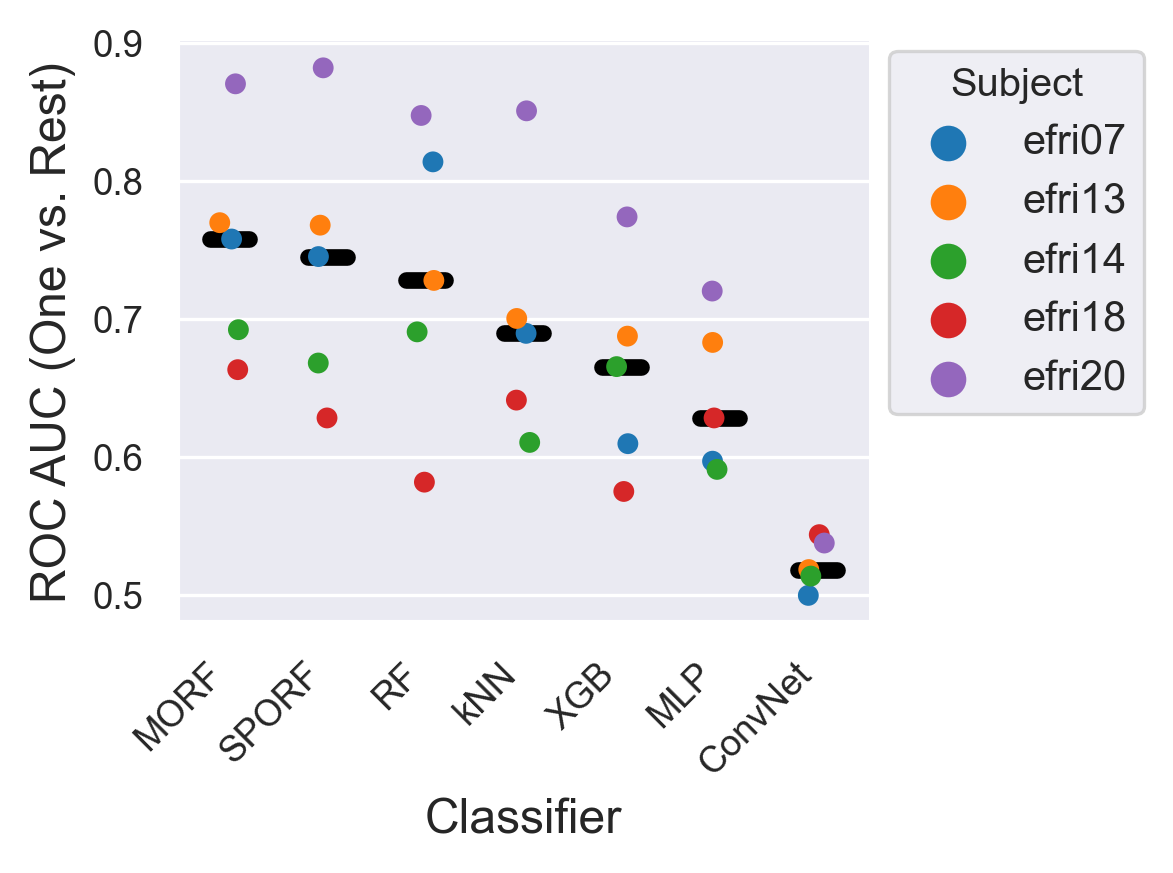

In [190]:
sns.set_style('darkgrid')
sns.set_context('paper')
plt.rcParams.update({
    "figure.titlesize" : "large",
    "axes.titlesize" : "large",
    "axes.labelsize" : "large"
})

width = 4
height = 3
aspect_ratio = 3/4  # 4:3 aspect ratio
fig, ax = plt.subplots(figsize=(width, height if height is not None else width*aspect_ratio), dpi=300, facecolor='w')
ax, df = plot_directionality_comparison(cohort_clf_scores, "roc_auc_ovr", ax=ax)
fig.tight_layout()
plt.savefig(figures_path / "pdf/efri_directionality_decoding_auroc.pdf", bbox_inches='tight');
plt.savefig(figures_path / "png/efri_directionality_decoding_auroc.png", bbox_inches='tight');
plt.show()

In [191]:
df

Subject Classifier  roc_auc_ovr
4    efri07       MORF     0.758005
9    efri07      SPORF     0.745303
14   efri07         RF     0.813876
19   efri07        kNN     0.689710
24   efri07        XGB     0.609848
29   efri07        MLP     0.597152
34   efri07    ConvNet     0.500000
39   efri13       MORF     0.769843
44   efri13      SPORF     0.768043
49   efri13         RF     0.728042
54   efri13        kNN     0.700491
59   efri13        XGB     0.687694
64   efri13        MLP     0.683138
69   efri13    ConvNet     0.518700
74   efri14       MORF     0.692372
79   efri14      SPORF     0.668233
84   efri14         RF     0.690797
89   efri14        kNN     0.610753
94   efri14        XGB     0.665633
99   efri14        MLP     0.591220
104  efri14    ConvNet     0.513972
109  efri18       MORF     0.663429
114  efri18      SPORF     0.628472
119  efri18         RF     0.581988
124  efri18        kNN     0.641387
129  efri18        XGB     0.575237
134  efri18        MLP     0.628472
139  efri18    ConvNet     0.543981
144  efri20       MORF     0.870370
149  efri20      SPORF     0.881944
154  efri20         RF     0.847467
159  efri20        kNN     0.850817
164  efri20        XGB     0.774020
169  efri20        MLP     0.720343
174  efri20    ConvNet     0.537908

### p-values between scores

In [57]:
from collections import defaultdict

df = defaultdict(list)
for subject, clf_scores in cohort_clf_scores.items():
    for clf_name, scores in clf_scores.items():
        df[clf_name].extend(scores[f"test_{metric}"])
df = pd.DataFrame(df)

In [52]:
comparison_test = dabest.load(df, idx=df.columns, id_col="index")
comparison_test.median_diff.statistical_tests

control     test  control_N  test_N        effect_size  is_paired  \
0    MORF    SPORF         25      25  median difference      False   
1    MORF       RF         25      25  median difference      False   
2    MORF      kNN         25      25  median difference      False   
3    MORF      XGB         25      25  median difference      False   
4    MORF      MLP         25      25  median difference      False   
5    MORF  ConvNet         25      25  median difference      False   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_kruskal  \
0   -0.006316  95 -0.071406  0.055140              0.5322    6.908083e-01   
1   -0.023577  95 -0.092894  0.063106              0.5096    6.071293e-01   
2   -0.056168  95 -0.116618  0.013300              0.1760    1.538367e-01   
3   -0.085986  95 -0.180716  0.004469              0.0238    2.149144e-02   
4   -0.108969  95 -0.182326 -0.038421              0.0016    3.287086e-03   
5   -0.232918  95 -0.269843 -0.174166              0.0000    5.709782e-08   

   statistic_kruskal  
0           0.158212  
1           0.264376  
2           2.033788  
3           5.286494  
4           8.640847  
5          29.459488

In [56]:
comparison_test.median_diff.lqrt

control     test  control_N  test_N  pvalue_lqrt_equal_var  \
0    MORF    SPORF         25      25                   0.84   
1    MORF       RF         25      25                   0.54   
2    MORF      kNN         25      25                   0.17   
3    MORF      XGB         25      25                   0.05   
4    MORF      MLP         25      25                   0.01   
5    MORF  ConvNet         25      25                   0.14   

   statistic_lqrt_equal_var  pvalue_lqrt_unequal_var  \
0                  0.038159                     0.84   
1                  0.399186                     0.55   
2                  2.142677                     0.17   
3                  6.470219                     0.05   
4                 10.235056                     0.01   
5                139.156935                     0.14   

   statistic_lqrt_unequal_var  
0                    0.038216  
1                    0.409289  
2                    2.144844  
3                    6.587733  
4                   10.276823  
5                  144.676641

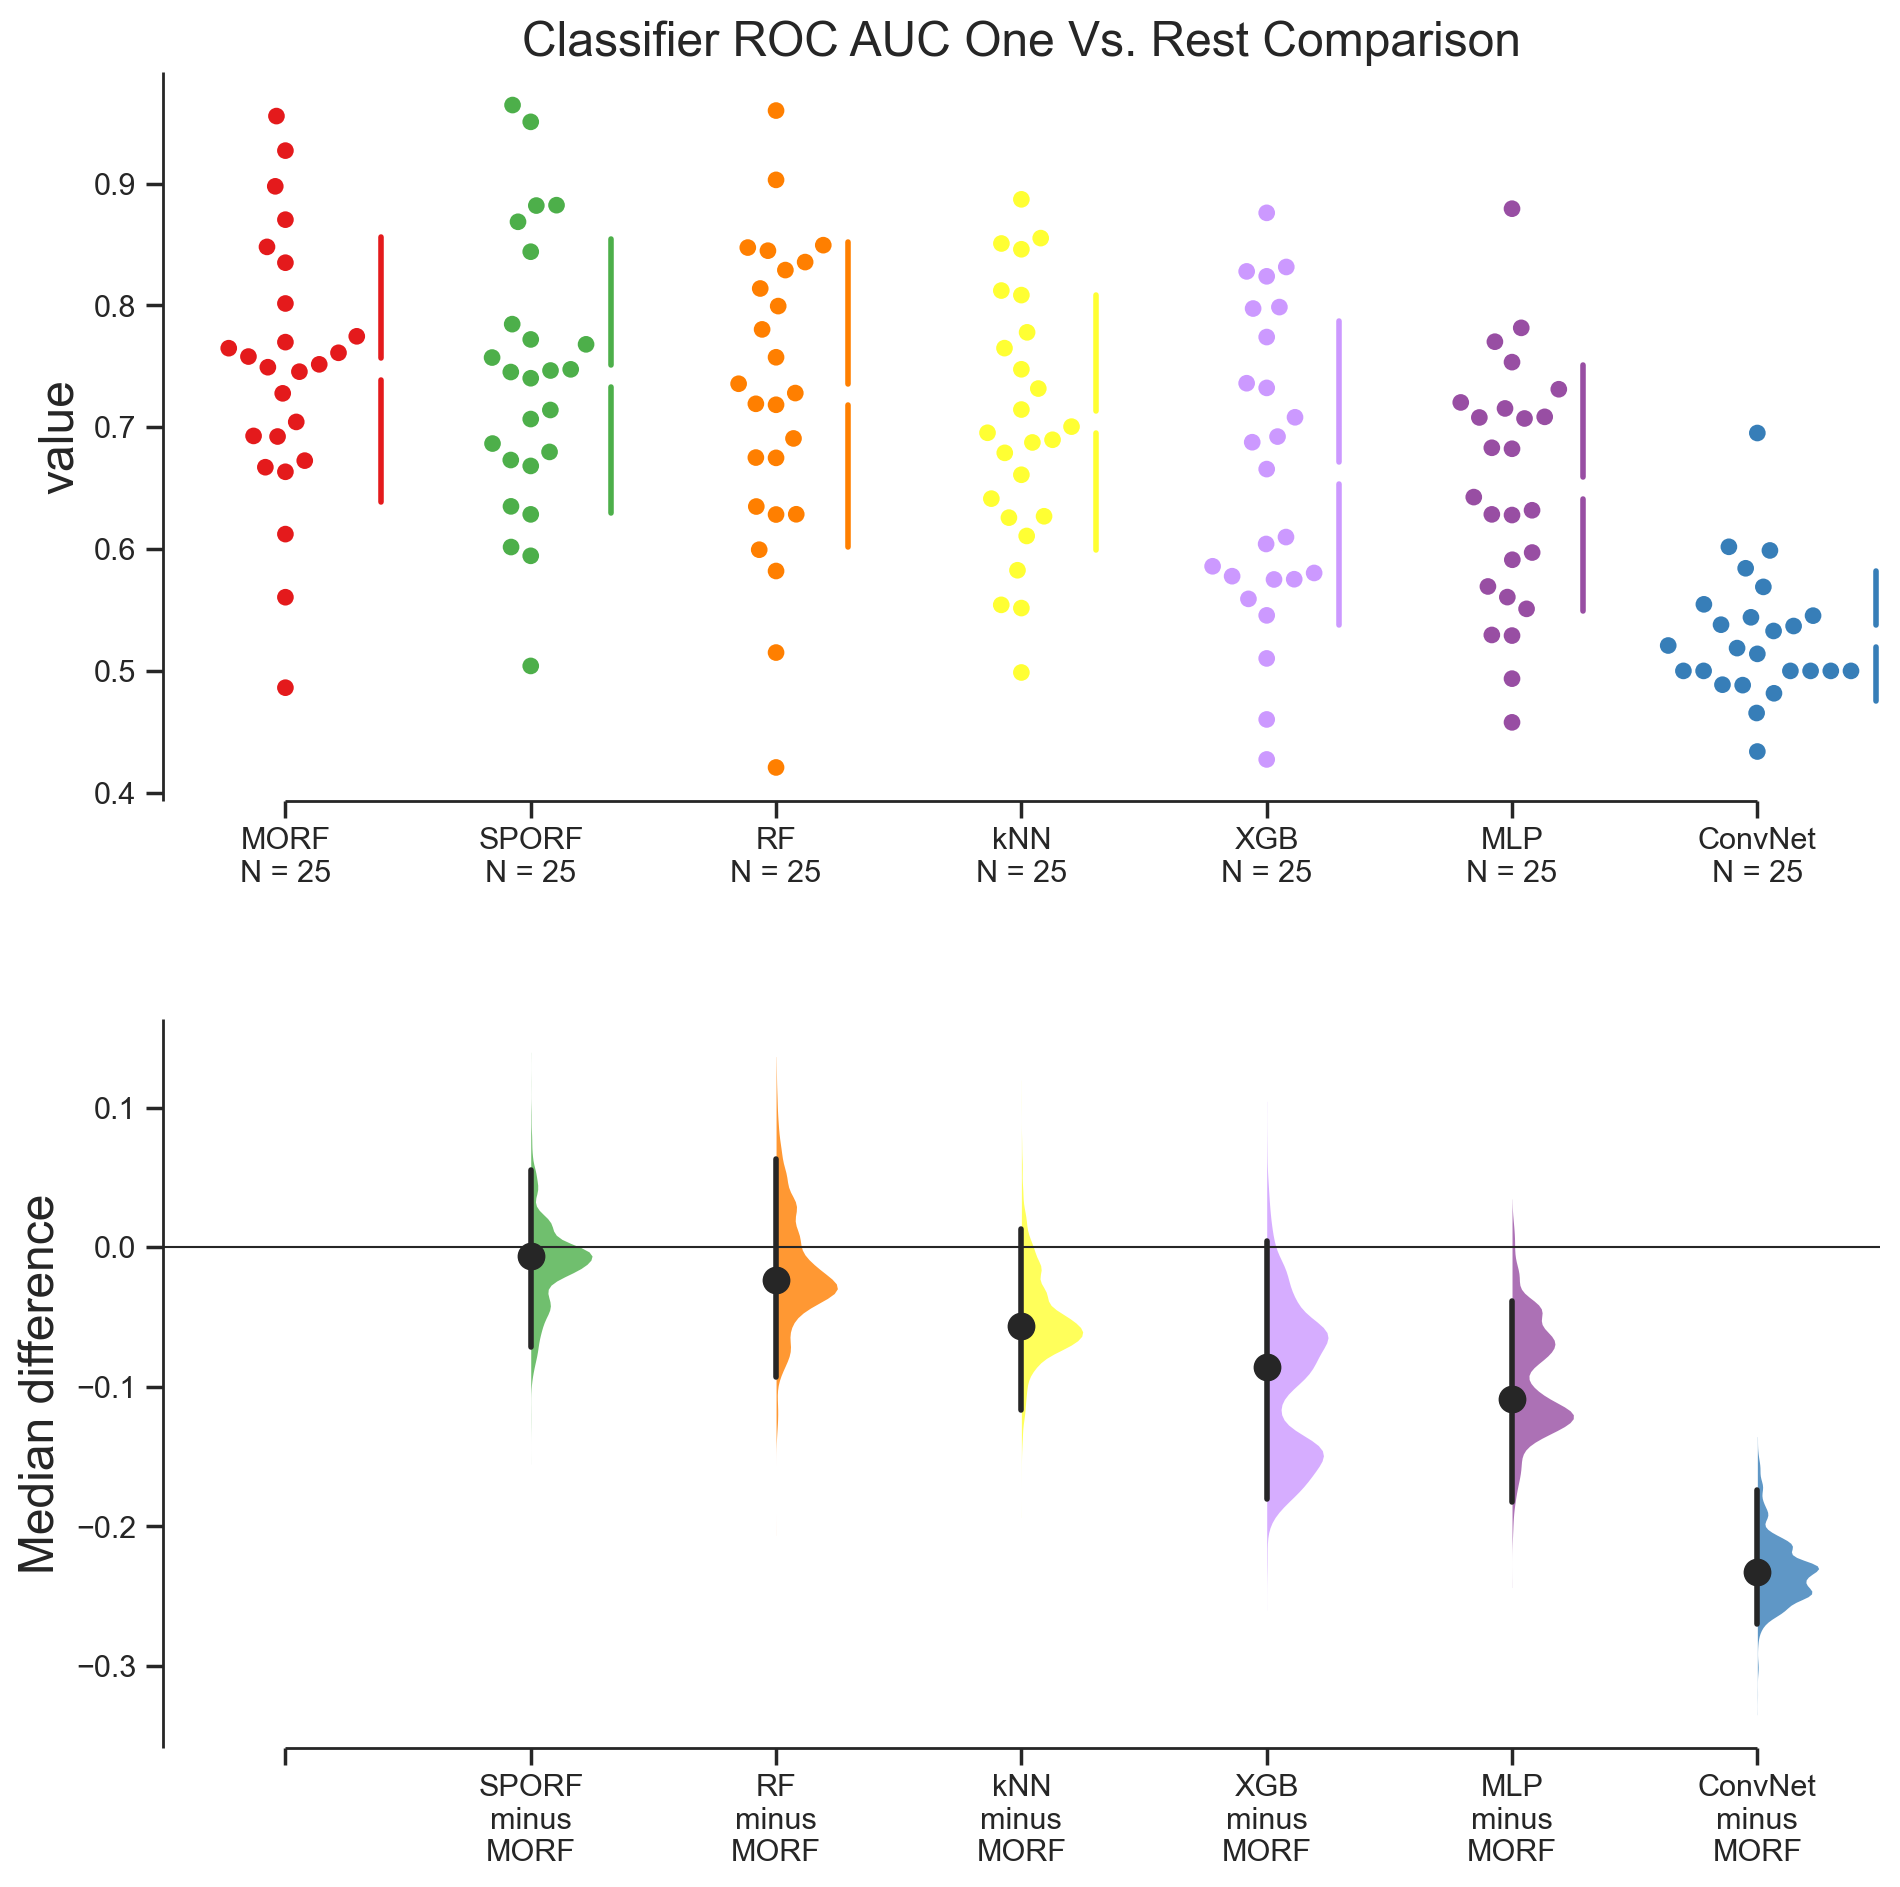

In [67]:
fig, ax = plt.subplots(dpi=200, figsize=(9.6, 4.8))
comparison_test.median_diff.plot(swarm_desat=1, ax=ax, custom_palette=palette)
ax.set_title("Classifier ROC AUC One Vs. Rest Comparison")
fig.tight_layout();

## ROC Curves

In [60]:
def _compute_multiclass_auroc(y_true, y_proba, n_classes):
    fprs = []
    tprs = []
    roc_auc = []

    for i in range(n_classes):
        mean_fpr = np.linspace(0, 1, 100)

        fpr, tpr, _ = roc_curve(
            label_binarize(y_true, classes=np.arange(n_classes))[:, i],
            y_proba[:, i],
        )

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0

        fprs.append(mean_fpr)
        tprs.append(interp_tpr)
        roc_auc.append(auc(fprs[i], tprs[i]))

    return fprs, tprs, roc_auc

In [61]:
def _compute_multiclass_roc(clf_pred_proba, pooled_ytest):
    clf_fprs = {}
    clf_tprs = {}
    clf_aucs = {}

    ## Compute FPR/TPR/AUROC for each classifier
    for clf_name, y_pred_probas in clf_pred_proba.items():
        clf_fprs[clf_name] = []
        clf_tprs[clf_name] = []
        clf_aucs[clf_name] = []

        # Compute ROC metrics for each fold
        for i, (y_pred_proba, y_test) in enumerate(zip(y_pred_probas, pooled_ytest)):
            y_pred_proba = np.array(y_pred_proba)

            # Compute ROC metrics for each class
            fpr, tpr, roc_auc = _compute_multiclass_auroc(y_test, y_pred_proba, 4)

            clf_fprs[clf_name].append(fpr)
            clf_tprs[clf_name].append(tpr)
            clf_aucs[clf_name].append(roc_auc)

        # n_folds x n_classes x 100
        clf_fprs[clf_name] = np.array(clf_fprs[clf_name])
        clf_tprs[clf_name] = np.array(clf_tprs[clf_name])
        clf_aucs[clf_name] = np.array(clf_aucs[clf_name])
    return clf_fprs, clf_tprs, clf_aucs

In [178]:
def plot_oneclass_roc_comparison(cohort_clf_scores, class_label, show_chance=True, ax=None):
    if not ax:
        width = 5
        aspect_ratio = 4/5  # 4:3 aspect ratio
        fig, ax = plt.subplots(dpi=300, figsize=(width, width*aspect_ratio), facecolor='w')

    ## Pool posterior probabilities by classifier and pool ground truth labels
    pooled_ytest = np.array([])
    clf_pred_proba = {}
    for subject_idx, (subject, clf_scores) in enumerate(cohort_clf_scores.items()):
        if subject_idx == 0:
            pooled_ytest = clf_scores["MORF"]["y_test"]
        else:
            new_ytest = clf_scores["MORF"]["y_test"]
            pooled_ytest = [np.hstack([cur, new]) for cur, new in zip(pooled_ytest, new_ytest)]
        
        for clf_name, scores in clf_scores.items():
            if subject_idx == 0:
                clf_pred_proba[clf_name] = scores["test_predict_proba"]
            else:
                cur_proba = clf_pred_proba[clf_name]
                new_proba = scores["test_predict_proba"]
                clf_pred_proba[clf_name] = [np.vstack([cur, new]) for cur, new in zip(cur_proba, new_proba)]

    clf_fprs, clf_tprs, clf_aucs = _compute_multiclass_roc(clf_pred_proba, pooled_ytest)

    ## Interpolate ROC curve and plot for each class
    for clf_name in clf_fprs:
        fprs = clf_fprs[clf_name]
        tprs = clf_tprs[clf_name]
        aucs = clf_aucs[clf_name]

        mean_fprs = np.mean(fprs, axis=0)
        mean_tprs = np.mean(tprs, axis=0)
        mean_tprs[:, -1] = 1.0

        mean_fpr = mean_fprs[class_label]
        mean_tpr = mean_tprs[class_label]
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs, axis=0)[class_label]

        ax.plot(
            mean_fpr,
            mean_tpr,
            label=r"{clf_name} ({mean_auc:.2f} $\pm$ {std_auc:.2f})".format(
                clf_name=clf_name,
                mean_auc=mean_auc,
                std_auc=std_auc,
            ),
            ls="-",
            lw=2,
            c=palette[clf_name]
        )
        # ax.set_title(label_names[class_label])

    if show_chance:
        ax.plot(
            [0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Chance", alpha=0.8
        )

    xlabel = "1-Specificity"# (Predicted Success Incorrectly)"
    ylabel = "Sensitivity"# (Predicted Success Correctly)"
    # ax.set_xlabel(xlabel, fontsize=16)
    # ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.legend(loc="lower right", frameon=False)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1.02), title='Model (AUC)')#, fontsize=10)

    title = f"Cross-Validated One vs. Rest ROC Curves\nof Classification Models ({label_names[class_label]})"
    # ax.set_title(title, fontsize=20)
    # ax.set_title(title)
    plt.tight_layout()
    return ax

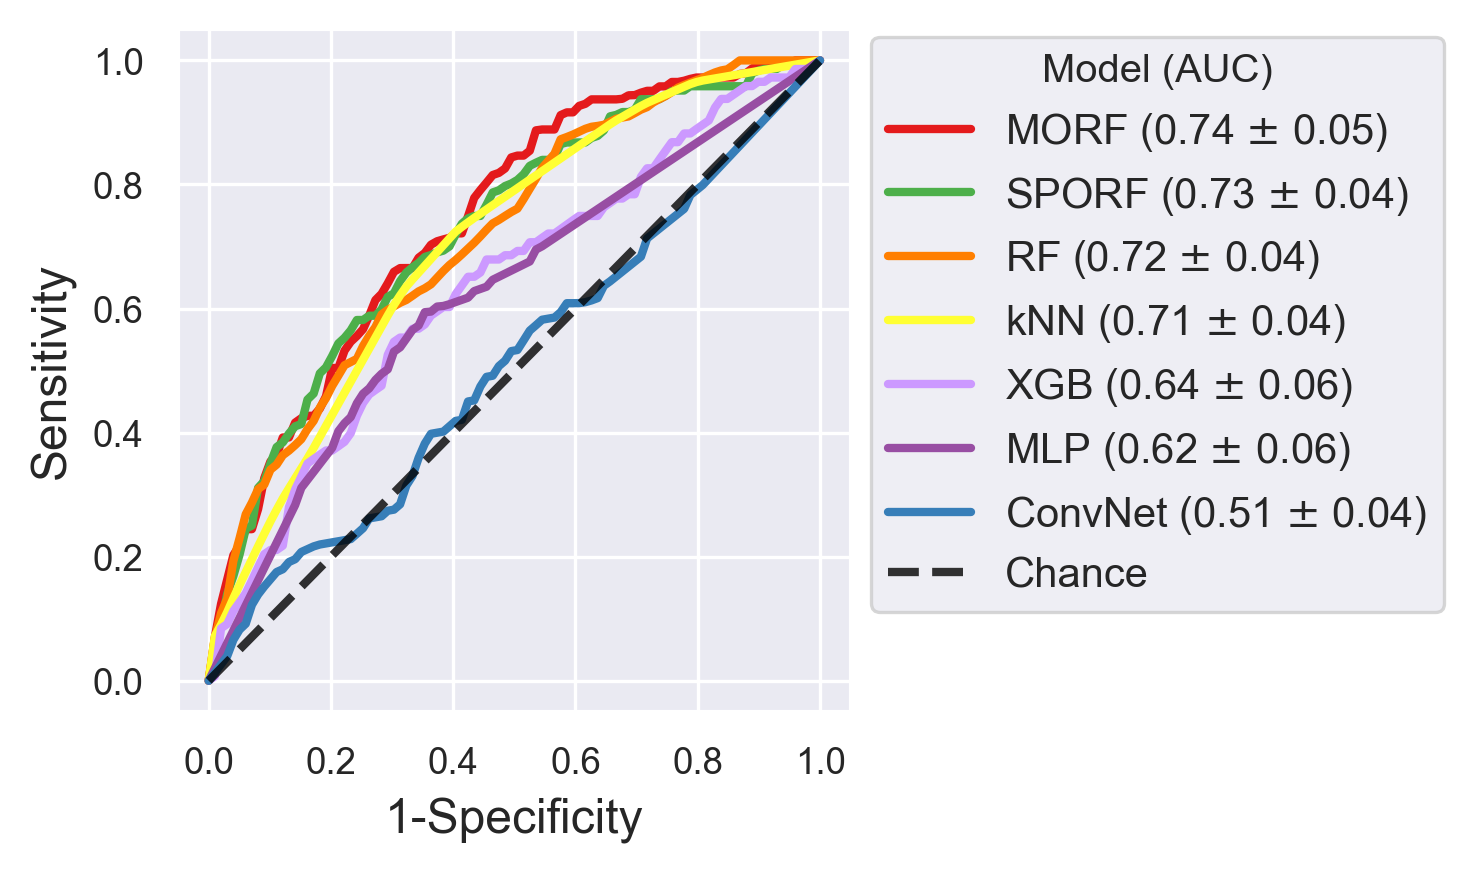

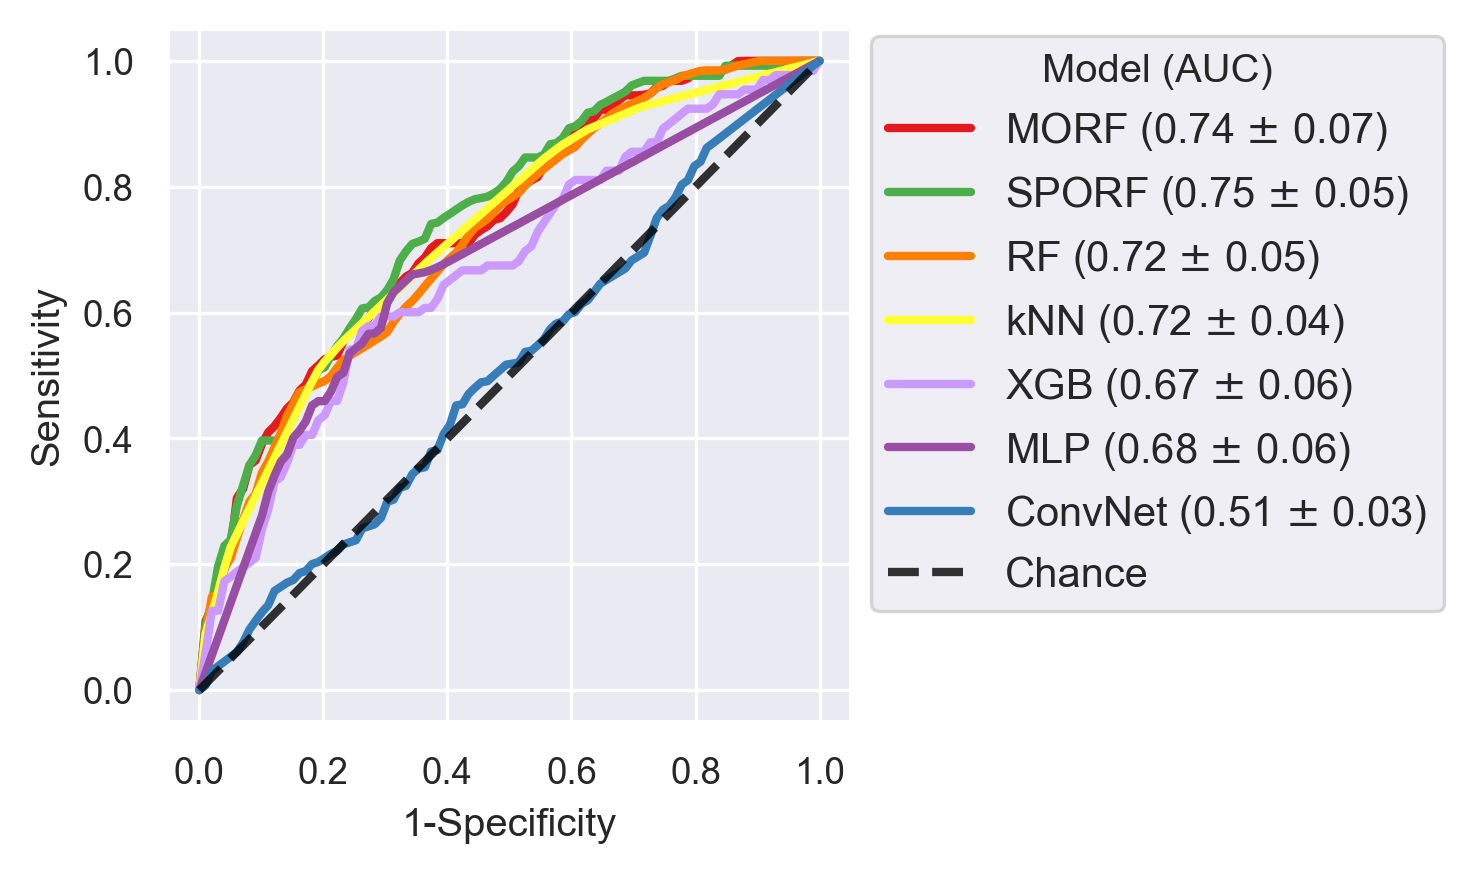

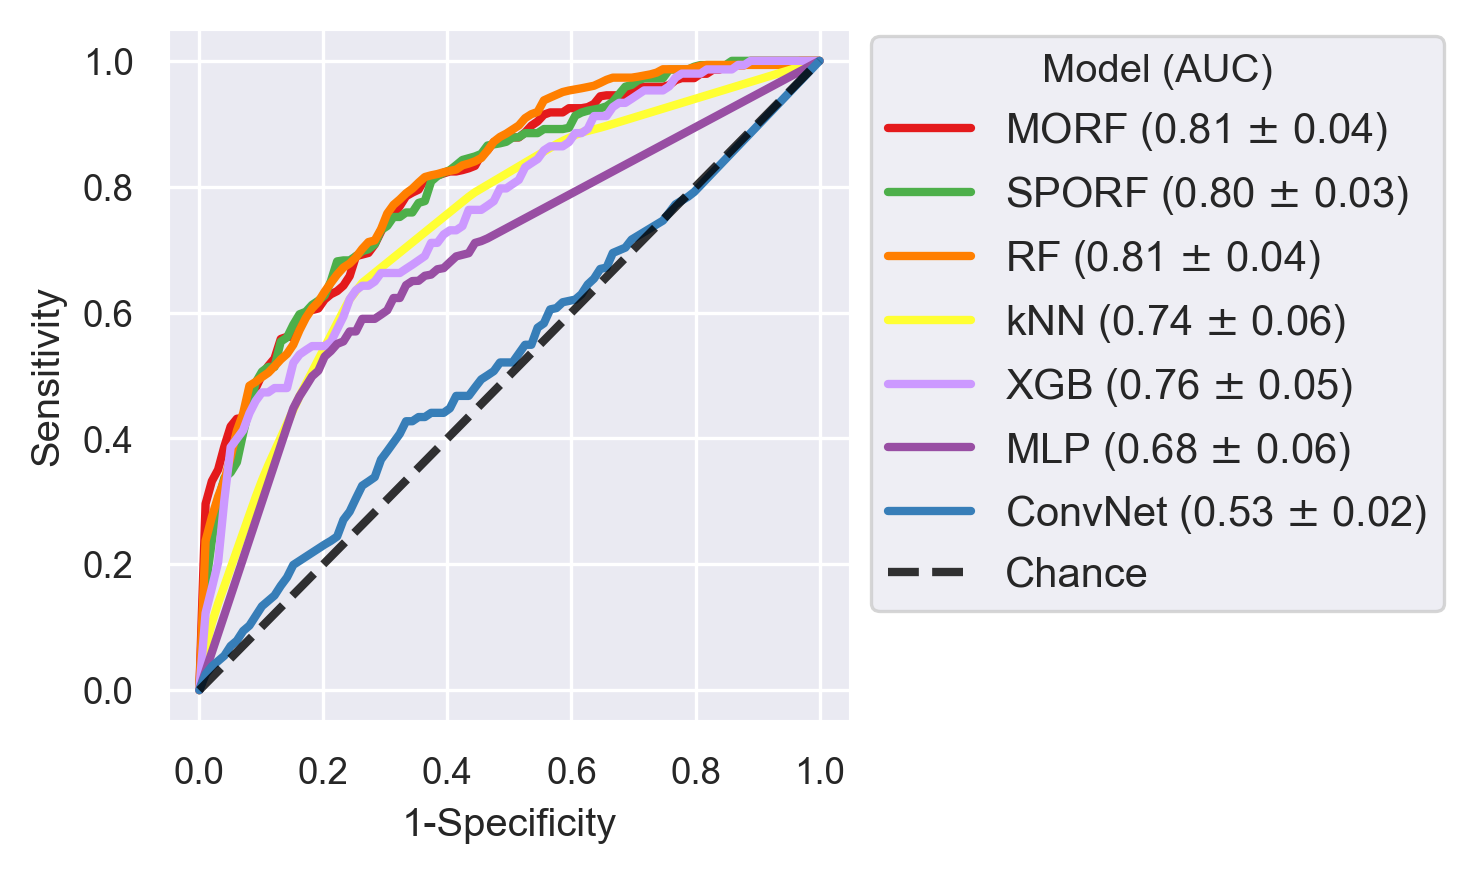

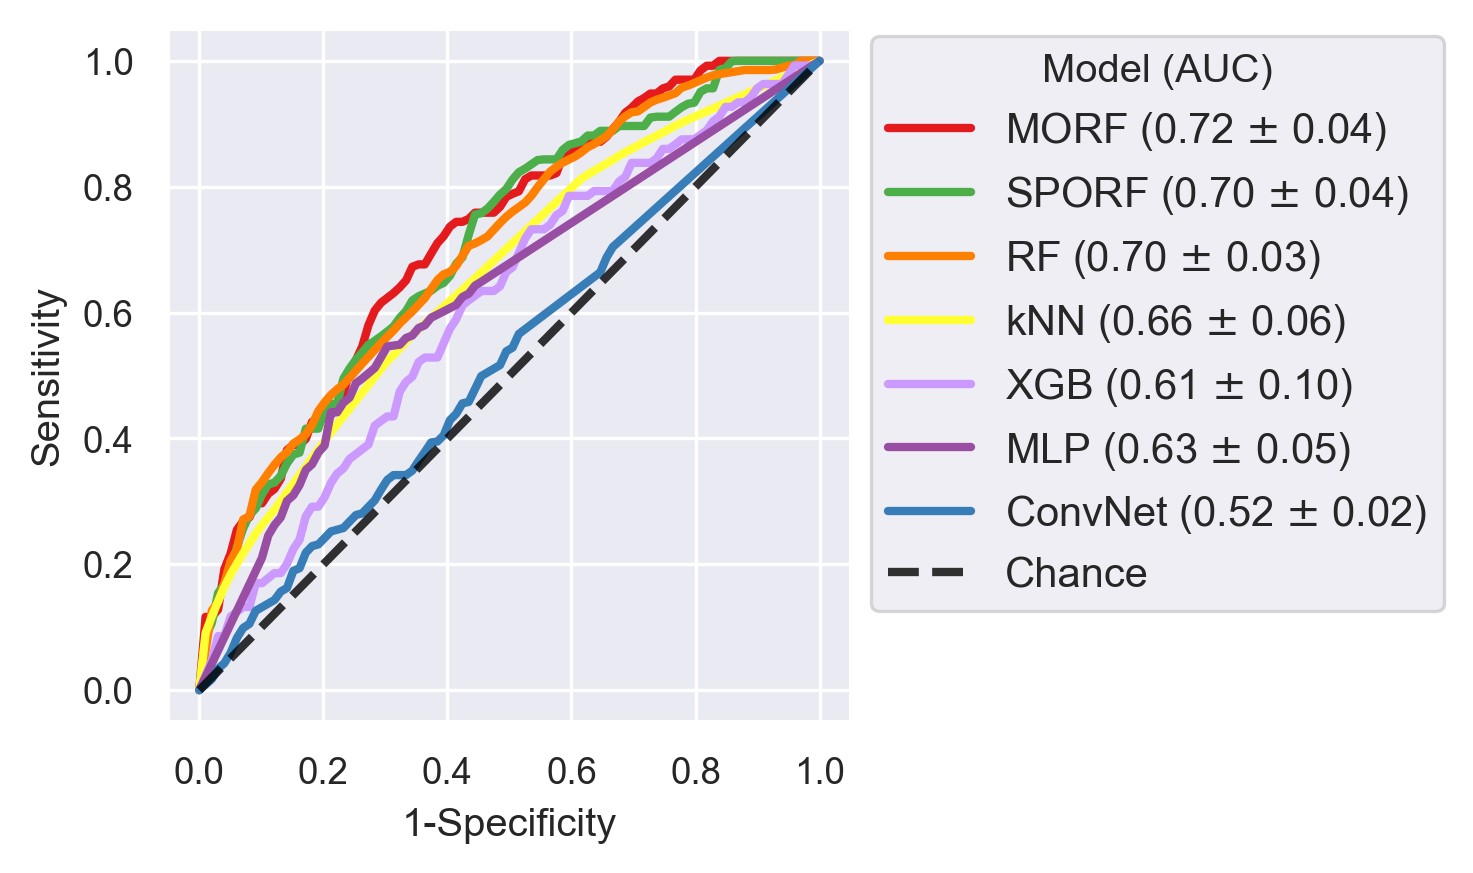

In [183]:
sns.set_style('darkgrid')
sns.set_context('paper')
plt.rcParams.update({
    "figure.titlesize" : "large",
    "axes.titlesize" : "large",
    "axes.labelsize" : "large",
    "legend.fontsize": "large"
})

width = 5
height = 3
aspect_ratio = 3/4  # 4:3 aspect ratio

for class_label in label_names:
    fig, ax = plt.subplots(figsize=(width, height if height is not None else width*aspect_ratio), dpi=300, facecolor='w')
    plot_oneclass_roc_comparison(cohort_clf_scores, class_label, show_chance=True, ax=ax);
    direction = label_names[class_label].lower()
    # plt.savefig(figures_path / f"pdf/efri_directionality_decoding_roc_curves_{direction}.pdf")
    plt.show()
    # break

In [164]:
def plot_multiclass_roc_comparison(cohort_clf_scores, show_chance=True, axs=None):
    if not axs:
        width = 16
        aspect_ratio = 3/4  # 4:3 aspect ratio
        fig, axs = plt.subplots(2, 2, dpi=300, figsize=(width, width*aspect_ratio), facecolor='w', sharex=True, sharey=True)
        axs = axs.flatten()

    ## Pool posterior probabilities by classifier and pool ground truth labels
    pooled_ytest = np.array([])
    clf_pred_proba = {}
    for subject_idx, (subject, clf_scores) in enumerate(cohort_clf_scores.items()):
        if subject_idx == 0:
            pooled_ytest = clf_scores["MORF"]["y_test"]
        else:
            new_ytest = clf_scores["MORF"]["y_test"]
            pooled_ytest = [np.hstack([cur, new]) for cur, new in zip(pooled_ytest, new_ytest)]
        
        for clf_name, scores in clf_scores.items():
            if subject_idx == 0:
                clf_pred_proba[clf_name] = scores["test_predict_proba"]
            else:
                cur_proba = clf_pred_proba[clf_name]
                new_proba = scores["test_predict_proba"]
                clf_pred_proba[clf_name] = [np.vstack([cur, new]) for cur, new in zip(cur_proba, new_proba)]

    clf_fprs, clf_tprs, clf_aucs = _compute_multiclass_roc(clf_pred_proba, pooled_ytest)

    ## Interpolate ROC curve and plot for each class
    for i, ax in enumerate(axs):
        for clf_name in clf_fprs:
            fprs = clf_fprs[clf_name]
            tprs = clf_tprs[clf_name]
            aucs = clf_aucs[clf_name]

            mean_fprs = np.mean(fprs, axis=0)
            mean_tprs = np.mean(tprs, axis=0)
            mean_tprs[:, -1] = 1.0

            mean_fpr = mean_fprs[i]
            mean_tpr = mean_tprs[i]
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs, axis=0)[i]

            ax.plot(
                mean_fpr,
                mean_tpr,
                label=r"{clf_name} Mean ROC (AUC = {mean_auc:.3f} $\pm$ {std_auc:.3f})".format(
                    clf_name=clf_name,
                    mean_auc=mean_auc,
                    std_auc=std_auc,
                ),
                ls="-",
                lw=2,
                c=palette[clf_name]
            )
            ax.set_title(label_names[i])

        if show_chance:
            ax.plot(
                [0, 1], [0, 1], linestyle="--", lw=3, color="r", label="Chance", alpha=0.8
            )

        xlabel = "1-Specificity\n(Predicted Success Incorrectly)"
        ylabel = "Sensitivity\n(Predicted Success Correctly)"
        if i % 2 == 1:
            ylabel = ""
        if i < 2:
            xlabel = ""
        # ax.set_xlabel(xlabel, fontsize=16)
        # ax.set_ylabel(ylabel, fontsize=16)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        title = f"{label_names[i]}"
        # ax.set_title(title, fontsize=20)
        ax.set_title(title)
        ax.legend(loc="lower right", frameon=False)

    fig.suptitle("Cross-Validated One vs. Rest ROC Curves of Classification Models", fontsize=24)
    fig.tight_layout()
    return axs

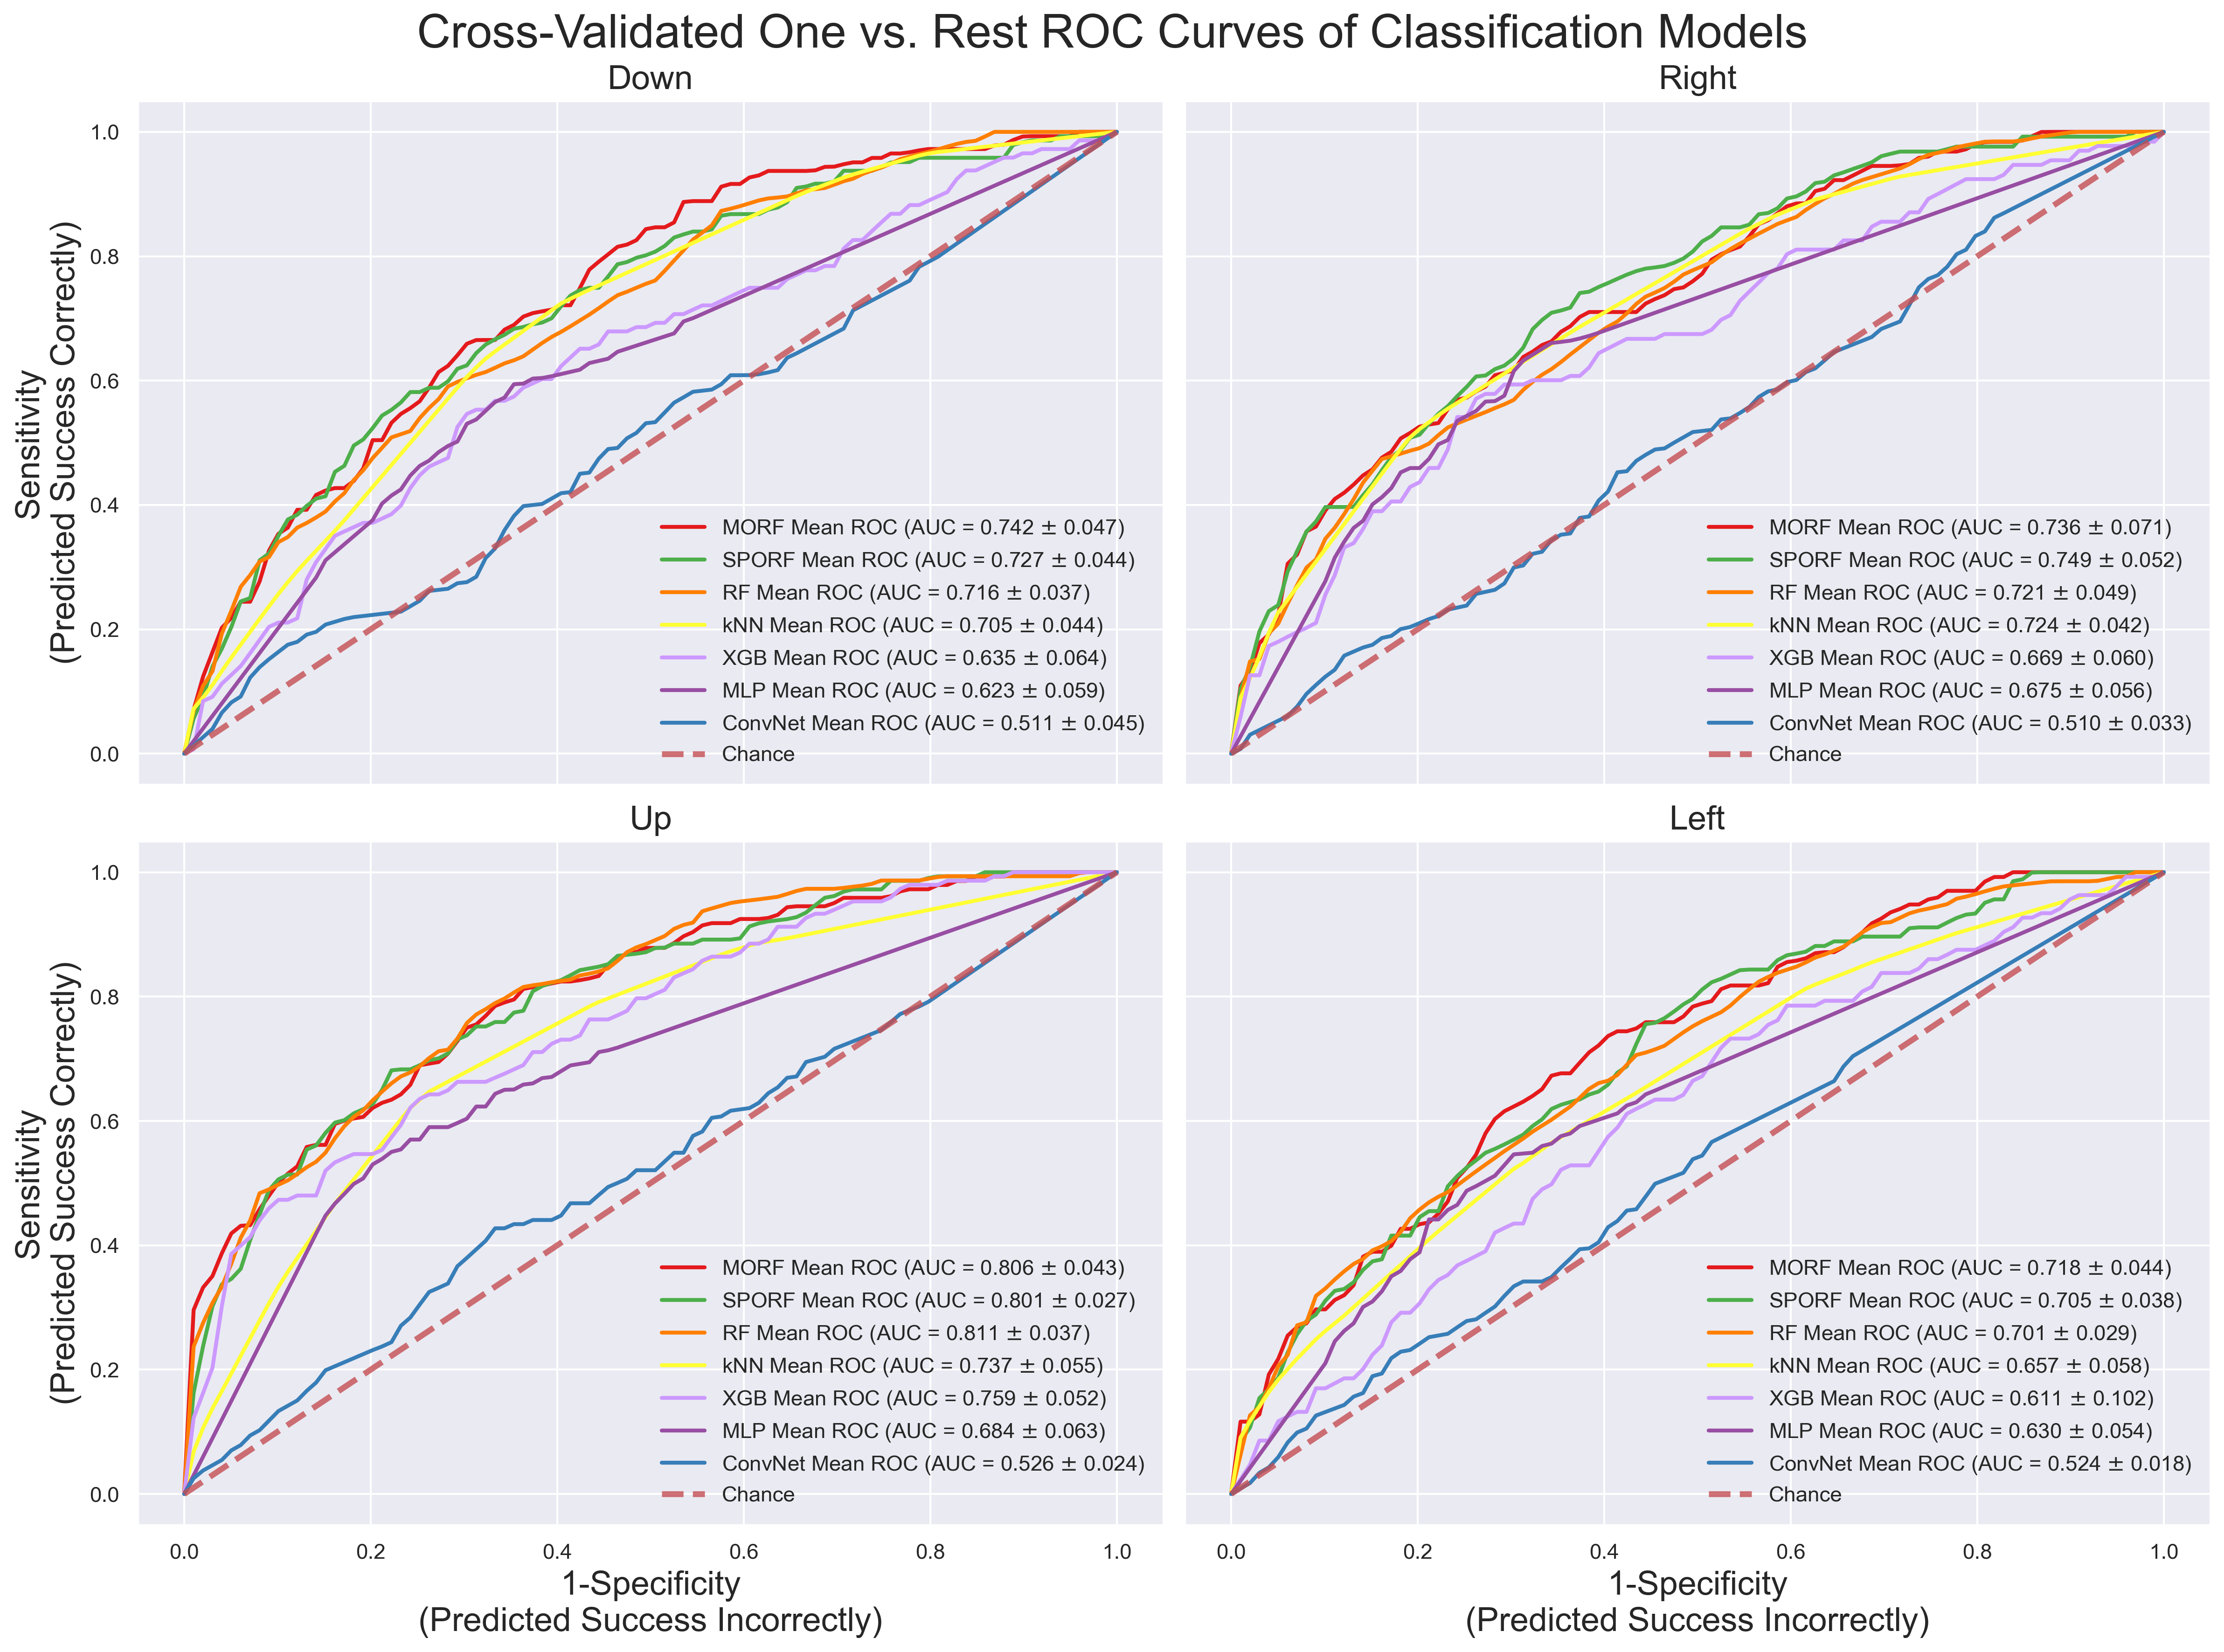

In [27]:
plt.rcParams.update({
    "figure.titlesize" : "xx-large",
    "axes.titlesize" : "xx-large",
    "axes.labelsize" : "xx-large"
})
plot_multiclass_roc_comparison(cohort_clf_scores, show_chance=True)
plt.savefig(figures_path / f"pdf/efri_directionality_decoding_roc_curves.pdf");